In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from scipy import stats
from statsmodels.stats.anova import AnovaRM
%matplotlib inline 

In [10]:
data_path = 'E:/Projects/2020_recurrentprocessing/Data/40/behavioral_40/'
behav_files=glob.glob(data_path+'/*.txt') # returns logfiles

In [11]:
df=pd.read_csv(behav_files[0], sep='\t', header=None, skiprows=1)
df=df.iloc[:,0:8] # remove NAN column
df.columns =['imageID', 'part_resp', 'trial_nr', 'masking', 'obj_category', 'correct_resp', 'part_accuracy', 'cond_num']

In [12]:
# Create a loop to generate a dataframe with all participants' performance
all_subj = []
for n_subj in range(len(behav_files)):
    df=pd.read_csv(behav_files[n_subj], sep='\t', header=None, skiprows=1)
    subj_idx = 'subj_' + behav_files[n_subj][behav_files[n_subj].find('log/')+len('log/'):behav_files[n_subj].rfind('.txt')]
    #print(subj_idx)
    df=df.iloc[:,0:8]
    df.columns =['imageID', 'part_resp', 'trial_nr', 'masking', 'obj_category', 'correct_resp', 'part_accuracy', 'cond_num']
    df['subj_idx'] = subj_idx
    df['resp'] = np.where(df['correct_resp'] == df['part_resp'], 1, 0)
    
    all_subj.append(df)
data = pd.concat(all_subj)

In [13]:
condi = {1: 1, 2: 2, 3: 3, 4: 4, 5: 1, 6: 2, 7: 3, 8: 4}
#condi = {1: 'seg', 2: 'low', 3: 'med', 4: 'high', 5: 'seg', 6: 'low', 7: 'med', 8: 'high'}
#data.replace({"cond_num": condi})
data['condition'] = data["cond_num"].replace(condi, inplace=False)
data.head(10)

,imageID,part_resp,trial_nr,masking,obj_category,correct_resp,part_accuracy,cond_num,subj_idx,resp,condition
0,h_fri_non_19,4,1,1,16,4,1,4,subj_Projects/2020_recurrentprocessing/Data/40...,1,4
1,l_bir_non_05,1,2,1,2,1,1,2,subj_Projects/2020_recurrentprocessing/Data/40...,1,2
2,s_hyd_seg_11,3,3,1,9,3,1,1,subj_Projects/2020_recurrentprocessing/Data/40...,1,1
3,l_cat_non_14,2,4,1,6,2,1,2,subj_Projects/2020_recurrentprocessing/Data/40...,1,2
4,l_cat_non_15,2,5,1,6,2,1,2,subj_Projects/2020_recurrentprocessing/Data/40...,1,2
5,m_fri_non_03,5,6,2,15,4,0,7,subj_Projects/2020_recurrentprocessing/Data/40...,0,3
6,m_cat_non_14,2,7,1,7,2,1,3,subj_Projects/2020_recurrentprocessing/Data/40...,1,3
7,l_sui_non_02,5,8,2,18,5,1,6,subj_Projects/2020_recurrentprocessing/Data/40...,1,2
8,h_sui_non_19,5,9,1,20,5,1,4,subj_Projects/2020_recurrentprocessing/Data/40...,1,4
9,m_hyd_non_24,1,10,2,11,3,0,7,subj_Projects/2020_recurrentprocessing/Data/40...,0,3


In [14]:
totalT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].count()
correctT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].sum()
totalT['resp'] = ((correctT['resp']/totalT['resp'].round(3)))*100

df = pd.DataFrame(totalT)
aovrm = AnovaRM(df, 'resp', 'subj_idx', within=['condition', 'masking'])
fit = aovrm.fit()
print(fit)


                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
condition         207.4106 3.0000 117.0000 0.0000
masking           146.0588 1.0000  39.0000 0.0000
condition:masking 185.6748 3.0000 117.0000 0.0000



In [15]:
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_ind_from_stats, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests

totalT1=totalT[totalT['masking']==1]

seg_vs_low = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 2]['resp'])
seg_vs_med = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 3]['resp'])
seg_vs_high = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 4]['resp'])
low_vs_med = ttest_rel(totalT1[totalT1['condition'] == 2]['resp'], totalT1[totalT1['condition'] == 3]['resp'])
low_vs_high = ttest_rel(totalT1[totalT1['condition'] == 2]['resp'], totalT1[totalT1['condition'] == 4]['resp'])
med_vs_high = ttest_rel(totalT1[totalT1['condition'] == 3]['resp'], totalT1[totalT1['condition'] == 4]['resp'])

stats =[seg_vs_low[1], seg_vs_med[1], seg_vs_high[1],low_vs_med[1], low_vs_high[1], med_vs_high[1]]

print("seg-low error - t-stat = %.3f; p-val = %.3f." % seg_vs_low)
print("seg-med error - t-stat = %.3f; p-val = %.3f." % seg_vs_med)
print("seg-high error - t-stat = %.3f; p-val = %.3f.\n" % seg_vs_high)

print ("low-med error - t-stat = %.3f; p-val = %.3f." % low_vs_med)
print ("low-high error - t-stat = %.3f; p-val = %.3f." % low_vs_high)
print ("med-high error - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high)

p_adjusted = multipletests(stats, method='sidak')
print (p_adjusted)

seg-low error - t-stat = 1.146; p-val = 0.259.
seg-med error - t-stat = 2.875; p-val = 0.007.
seg-high error - t-stat = 3.838; p-val = 0.000.

low-med error - t-stat = 0.973; p-val = 0.337.
low-high error - t-stat = 2.159; p-val = 0.037.
med-high error - t-stat = 1.066; p-val = 0.293.

(array([False,  True,  True, False, False, False]), array([0.83398477, 0.0384567 , 0.00265767, 0.91480909, 0.20281254,
       0.8749322 ]), 0.008512444610847103, 0.008333333333333333)


In [16]:
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_ind_from_stats, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests

totalT2=totalT[totalT['masking']==2]

seg_vs_low = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 2]['resp'])
seg_vs_med = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 3]['resp'])
seg_vs_high = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 4]['resp'])
low_vs_med = ttest_rel(totalT2[totalT2['condition'] == 2]['resp'], totalT2[totalT2['condition'] == 3]['resp'])
low_vs_high = ttest_rel(totalT2[totalT2['condition'] == 2]['resp'], totalT2[totalT2['condition'] == 4]['resp'])
med_vs_high = ttest_rel(totalT2[totalT2['condition'] == 3]['resp'], totalT2[totalT2['condition'] == 4]['resp'])

stats =[seg_vs_low[1], seg_vs_med[1], seg_vs_high[1],low_vs_med[1], low_vs_high[1], med_vs_high[1]]

print("seg-low error - t-stat = %.3f; p-val = %.3f." % seg_vs_low)
print("seg-med error - t-stat = %.3f; p-val = %.3f." % seg_vs_med)
print("seg-high error - t-stat = %.3f; p-val = %.3f.\n" % seg_vs_high)

print ("low-med error - t-stat = %.3f; p-val = %.3f." % low_vs_med)
print ("low-high error - t-stat = %.3f; p-val = %.3f." % low_vs_high)
print ("med-high error - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high)

p_adjusted = multipletests(stats, method='sidak')
print (p_adjusted)

seg-low error - t-stat = 8.708; p-val = 0.000.
seg-med error - t-stat = 14.390; p-val = 0.000.
seg-high error - t-stat = 20.713; p-val = 0.000.

low-med error - t-stat = 12.796; p-val = 0.000.
low-high error - t-stat = 17.448; p-val = 0.000.
med-high error - t-stat = 4.213; p-val = 0.000.

(array([ True,  True,  True,  True,  True,  True]), array([6.63547217e-10, 0.00000000e+00, 0.00000000e+00, 9.32587341e-15,
       0.00000000e+00, 8.63527141e-04]), 0.008512444610847103, 0.008333333333333333)


In [17]:
condi = {1: 'seg_unmasked', 2: 'low_unmasked', 3: 'med_unmasked', 4: 'high_unmasked', 5: 'seg_masked', 6: 'low_masked', 7: 'med_masked', 8: 'high_masked'}
data["cond_num"].replace(condi, inplace=True)
masdi = {1: 'unmasked', 2: 'masked'}
data["masking"].replace(masdi, inplace=True)

##### Make pretty plot:

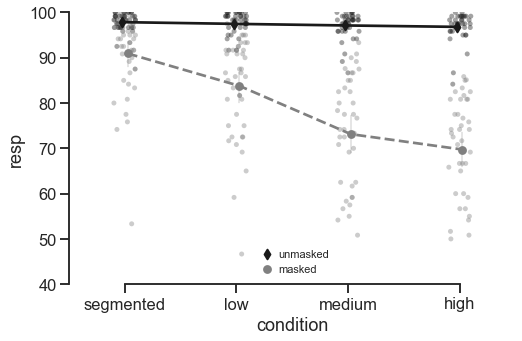

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
sns.set_context('talk')

masdi = {1: 'unmasked', 2: 'masked'}
data["masking"].replace(masdi, inplace=True)
condi = {1: 'segmented', 2: 'low', 3: "medium", 4:"high"}
data["condition"].replace(condi, inplace=True)

totalT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].count()
correctT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].sum()
totalT['resp'] = ((correctT['resp']/totalT['resp'].round(3)))*100

# Initialize the figure
f, ax = plt.subplots(figsize=(8,5))
sns.set(style="whitegrid")
sns.color_palette("Paired")

# Show each observation with a scatterplot
sns.stripplot(x="condition", y="resp", hue="masking",hue_order=['unmasked','masked'],palette = ['k', 'gray'],
              data=totalT, dodge=False, jitter=True,
              alpha=.4, zorder=1,order=["segmented", "low","medium", "high"])

# Show the conditional means
sns.pointplot(x="condition", y="resp", hue="masking",hue_order=['unmasked','masked'],palette = ['k', 'gray'],
              linestyles = ['-', '--'], 
              data=totalT, dodge=.05, join=True,markers=["d", "o"],errwidth=.4,
                scale=1,order=["segmented", "low","medium", "high"],bw=.2)

# Improve legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:],
          handletextpad=0, columnspacing=0.1,
          loc="lower center", frameon=False)

ax.set(ylim=(40,100))
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 3.5})
sns.despine(trim=True)
f.savefig("human_behav.tif")


### Repeat for confirmatory dataset 

In [30]:
data_path = 'E:/Projects/2020_recurrentprocessing/Data/extra20/behavioral/log/'
behav_files=glob.glob(data_path+'/*.txt') # returns logfiles

In [31]:
df=pd.read_csv(behav_files[0], sep='\t', header=None, skiprows=1)
df=df.iloc[:,0:8] # remove NAN column
df.columns =['imageID', 'part_resp', 'trial_nr', 'masking', 'obj_category', 'correct_resp', 'part_accuracy', 'cond_num']

In [32]:
# Create a loop to generate a dataframe with all participants' performance
all_subj = []
for n_subj in range(len(behav_files)):
    df=pd.read_csv(behav_files[n_subj], sep='\t', header=None, skiprows=1)
    subj_idx = 'subj_' + behav_files[n_subj][behav_files[n_subj].find('log/')+len('log/'):behav_files[n_subj].rfind('.txt')]
    #print(subj_idx)
    df=df.iloc[:,0:8]
    df.columns =['imageID', 'part_resp', 'trial_nr', 'masking', 'obj_category', 'correct_resp', 'part_accuracy', 'cond_num']
    df['subj_idx'] = subj_idx
    df['resp'] = np.where(df['correct_resp'] == df['part_resp'], 1, 0)
    
    all_subj.append(df)
data = pd.concat(all_subj)

In [33]:
condi = {1: 1, 2: 2, 3: 3, 4: 4, 5: 1, 6: 2, 7: 3, 8: 4}
data['condition'] = data["cond_num"].replace(condi, inplace=False)
data.head(10)

,imageID,part_resp,trial_nr,masking,obj_category,correct_resp,part_accuracy,cond_num,subj_idx,resp,condition
0,m_fri_non_15,6,1,1,15,4,0,3,subj_Projects/2020_recurrentprocessing/Data/ex...,0,3
1,s_sui_seg_19,6,2,1,17,5,0,1,subj_Projects/2020_recurrentprocessing/Data/ex...,0,1
2,l_hyd_non_19,6,3,2,10,3,0,6,subj_Projects/2020_recurrentprocessing/Data/ex...,0,2
3,m_bir_non_17,6,4,2,3,1,0,7,subj_Projects/2020_recurrentprocessing/Data/ex...,0,3
4,m_sui_non_17,5,5,1,19,5,1,3,subj_Projects/2020_recurrentprocessing/Data/ex...,1,3
5,l_fri_non_09,4,6,1,14,4,1,2,subj_Projects/2020_recurrentprocessing/Data/ex...,1,2
6,s_cat_seg_06,4,7,2,5,2,0,5,subj_Projects/2020_recurrentprocessing/Data/ex...,0,1
7,s_hyd_seg_12,4,8,2,9,3,0,5,subj_Projects/2020_recurrentprocessing/Data/ex...,0,1
8,h_hyd_non_20,2,9,1,12,3,0,4,subj_Projects/2020_recurrentprocessing/Data/ex...,0,4
9,m_sui_non_11,2,10,2,19,5,0,7,subj_Projects/2020_recurrentprocessing/Data/ex...,0,3


In [34]:
totalT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].count()
correctT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].sum()
totalT['resp'] = ((correctT['resp']/totalT['resp'].round(3)))*100

df = pd.DataFrame(totalT)
aovrm = AnovaRM(df, 'resp', 'subj_idx', within=['condition', 'masking'])
fit = aovrm.fit()
print(fit)


                     Anova
                  F Value  Num DF  Den DF Pr > F
------------------------------------------------
condition         117.8802 3.0000 57.0000 0.0000
masking           122.3181 1.0000 19.0000 0.0000
condition:masking 101.3338 3.0000 57.0000 0.0000



In [35]:
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_ind_from_stats, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests

totalT1=totalT[totalT['masking']==1]

seg_vs_low = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 2]['resp'])
seg_vs_med = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 3]['resp'])
seg_vs_high = ttest_rel(totalT1[totalT1['condition'] == 1]['resp'], totalT1[totalT1['condition'] == 4]['resp'])
low_vs_med = ttest_rel(totalT1[totalT1['condition'] == 2]['resp'], totalT1[totalT1['condition'] == 3]['resp'])
low_vs_high = ttest_rel(totalT1[totalT1['condition'] == 2]['resp'], totalT1[totalT1['condition'] == 4]['resp'])
med_vs_high = ttest_rel(totalT1[totalT1['condition'] == 3]['resp'], totalT1[totalT1['condition'] == 4]['resp'])

stats =[seg_vs_low[1], seg_vs_med[1], seg_vs_high[1],low_vs_med[1], low_vs_high[1], med_vs_high[1]]

print("seg-low error - t-stat = %.3f; p-val = %.3f." % seg_vs_low)
print("seg-med error - t-stat = %.3f; p-val = %.3f." % seg_vs_med)
print("seg-high error - t-stat = %.3f; p-val = %.3f.\n" % seg_vs_high)

print ("low-med error - t-stat = %.3f; p-val = %.3f." % low_vs_med)
print ("low-high error - t-stat = %.3f; p-val = %.3f." % low_vs_high)
print ("med-high error - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high)

p_adjusted = multipletests(stats, method='sidak')
print (p_adjusted)

seg-low error - t-stat = -0.127; p-val = 0.900.
seg-med error - t-stat = 3.470; p-val = 0.003.
seg-high error - t-stat = 3.472; p-val = 0.003.

low-med error - t-stat = 4.233; p-val = 0.000.
low-high error - t-stat = 4.311; p-val = 0.000.
med-high error - t-stat = 1.445; p-val = 0.165.

(array([False,  True,  True,  True,  True, False]), array([0.99999902, 0.01527914, 0.01521193, 0.00269754, 0.00225827,
       0.6604786 ]), 0.008512444610847103, 0.008333333333333333)


In [36]:
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_ind_from_stats, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests

totalT2=totalT[totalT['masking']==2]

seg_vs_low = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 2]['resp'])
seg_vs_med = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 3]['resp'])
seg_vs_high = ttest_rel(totalT2[totalT2['condition'] == 1]['resp'], totalT2[totalT2['condition'] == 4]['resp'])
low_vs_med = ttest_rel(totalT2[totalT2['condition'] == 2]['resp'], totalT2[totalT2['condition'] == 3]['resp'])
low_vs_high = ttest_rel(totalT2[totalT2['condition'] == 2]['resp'], totalT2[totalT2['condition'] == 4]['resp'])
med_vs_high = ttest_rel(totalT2[totalT2['condition'] == 3]['resp'], totalT2[totalT2['condition'] == 4]['resp'])

stats =[seg_vs_low[1], seg_vs_med[1], seg_vs_high[1],low_vs_med[1], low_vs_high[1], med_vs_high[1]]

print("seg-low error - t-stat = %.3f; p-val = %.3f." % seg_vs_low)
print("seg-med error - t-stat = %.3f; p-val = %.3f." % seg_vs_med)
print("seg-high error - t-stat = %.3f; p-val = %.3f.\n" % seg_vs_high)

print ("low-med error - t-stat = %.3f; p-val = %.3f." % low_vs_med)
print ("low-high error - t-stat = %.3f; p-val = %.3f." % low_vs_high)
print ("med-high error - t-stat = %.3f; p-val = %.3f.\n" % med_vs_high)

p_adjusted = multipletests(stats, method='sidak')
print (p_adjusted)

seg-low error - t-stat = 6.999; p-val = 0.000.
seg-med error - t-stat = 11.296; p-val = 0.000.
seg-high error - t-stat = 13.682; p-val = 0.000.

low-med error - t-stat = 11.510; p-val = 0.000.
low-high error - t-stat = 12.733; p-val = 0.000.
med-high error - t-stat = 2.178; p-val = 0.042.

(array([ True,  True,  True,  True,  True, False]), array([6.89767771e-06, 4.28784941e-09, 1.64684266e-10, 3.13357340e-09,
       5.67117020e-10, 2.27789289e-01]), 0.008512444610847103, 0.008333333333333333)


In [37]:
condi = {1: 'seg_unmasked', 2: 'low_unmasked', 3: 'med_unmasked', 4: 'high_unmasked', 5: 'seg_masked', 6: 'low_masked', 7: 'med_masked', 8: 'high_masked'}
data["cond_num"].replace(condi, inplace=True)
masdi = {1: 'unmasked', 2: 'masked'}
data["masking"].replace(masdi, inplace=True)

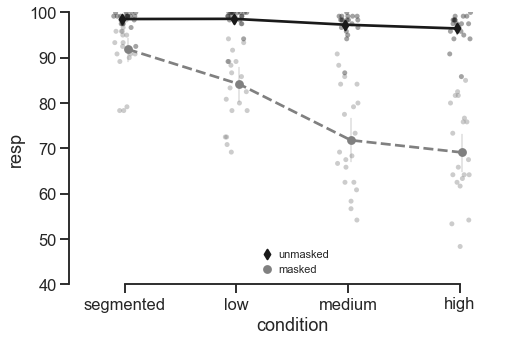

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
sns.set_context('talk')

masdi = {1: 'unmasked', 2: 'masked'}
data["masking"].replace(masdi, inplace=True)
condi = {1: 'segmented', 2: 'low', 3: "medium", 4:"high"}
data["condition"].replace(condi, inplace=True)

totalT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].count()
correctT = data.groupby(['subj_idx', 'condition', 'masking'], as_index=False)['resp'].sum()
totalT['resp'] = ((correctT['resp']/totalT['resp'].round(3)))*100


# Initialize the figure
f, ax = plt.subplots(figsize=(8,5))
#sns.despine(bottom=True, left=True)
sns.set(style="whitegrid")
sns.color_palette("Paired")
# Show each observation with a scatterplot
sns.stripplot(x="condition", y="resp", hue="masking",hue_order=['unmasked','masked'],
              data=totalT, dodge=False, jitter=True, palette = ['k', 'gray'],
              alpha=.4, zorder=1,order=["segmented", "low","medium", "high"])

# Show the conditional means
sns.pointplot(x="condition", y="resp", hue="masking",hue_order=['unmasked','masked'],
              data=totalT, dodge=.05, join=True, palette = ['k', 'gray'],markers=["d", "o"],errwidth=.4, 
              linestyles = ['-', '--'],                
              scale=1,order=["segmented", "low","medium", "high"],bw=.2)


# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:],
          handletextpad=0, columnspacing=0.1,
          loc="lower center", frameon=False)

ax.set(ylim=(40,100))

sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 3.5})
sns.despine(trim=True)

f.savefig("human_behav_confirmatory.tif")


## Deep Convolutional Neural Network behavior

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau, norm, ttest_1samp
from scipy.stats import t as t_dist
from scipy.spatial.distance import squareform, pdist
from copy import deepcopy
from scipy.interpolate import interp1d
import warnings
import itertools
from joblib import Parallel, delayed
import six
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes as procrust
from scipy.ndimage import label, generate_binary_structure
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
MAX_INT = np.iinfo(np.int32).max

def _permute_sign(data, random_state=None):
    random_state = check_random_state(random_state)
    return np.mean(data*random_state.choice([1, -1], len(data)))


def _permute_group(data, random_state=None):
    random_state = check_random_state(random_state)
    perm_label = random_state.permutation(data['Group'])
    return (np.mean(data.loc[perm_label == 1, 'Values']) - np.mean(data.loc[perm_label == 0, 'Values']))


def _permute_func(data1, data2, metric, random_state=None):
    """ Helper function for matrix_permutation.
        Can take a functon, that would be repeated for calculation.
        Args:
            data1: (np.array) squareform matrix
            data2: flattened np array (same size upper triangle of data1)
            metric: similarity/distance function from scipy.stats (e.g., spearman, pearson, kendall etc)
            random_state: random_state instance for permutation
        Returns:
            r: r value of function
    """
    random_state = check_random_state(random_state)

    data_row_id = range(data1.shape[0])
    permuted_ix = random_state.choice(data_row_id,
                                      size=len(data_row_id), replace=False)
    new_fmri_dist = data1.iloc[permuted_ix, permuted_ix].values
    new_fmri_dist = new_fmri_dist[np.triu_indices(new_fmri_dist.shape[0], k=1)]
    return correlation(new_fmri_dist, data2, metric=metric)[0]


def _calc_pvalue(all_p, stat, tail):
    """Calculates p value based on distribution of correlations
    This function is called by the permutation functions
        all_p: list of correlation values from permutation
        stat: actual value being tested, i.e., stats['correlation'] or stats['mean']
        tail: (int) either 2 or 1 for two-tailed p-value or one-tailed
    """
    
    denom = float(len(all_p)) + 1
    if tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    elif tail == 1:
        if stat >= 0:
            numer = np.sum(all_p >= stat) + 1
        else:
            numer = np.sum(all_p <= stat) + 1
    else:
        raise ValueError('tail must be either 1 or 2')
    p = numer / denom
    return p

def one_sample_permutation(data, n_permute=5000, tail=2, n_jobs=-1, return_perms=False, random_state=None):
    ''' One sample permutation test using randomization.

        Args:
            data: (pd.DataFrame, pd.Series, np.array) data to permute
            n_permute: (int) number of permutations
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False

        Returns:
            stats: (dict) dictionary of permutation results ['mean','p']

    '''

    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)

    data = np.array(data)
    stats = dict()
    stats['mean'] = np.nanmean(data)

    all_p = Parallel(n_jobs=n_jobs)(delayed(_permute_sign)(data,
                                                           random_state=seeds[i]) for i in range(n_permute))
    stats['p'] = _calc_pvalue(all_p, stats['mean'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats


def two_sample_permutation(data1, data2, n_permute=5000,
                           tail=2, n_jobs=-1, return_perms=False, random_state=None):
    ''' Independent sample permutation test.

        Args:
            data1: (pd.DataFrame, pd.Series, np.array) dataset 1 to permute
            data2: (pd.DataFrame, pd.Series, np.array) dataset 2 to permute
            n_permute: (int) number of permutations
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False
        Returns:
            stats: (dict) dictionary of permutation results ['mean','p']

    '''

    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)

    stats = dict()
    stats['mean'] = np.nanmean(data1)-np.nanmean(data2)
    data = pd.DataFrame(data={'Values': data1, 'Group': np.ones(len(data1))})
    data = data.append(pd.DataFrame(data={
                                        'Values': data2,
                                        'Group': np.zeros(len(data2))}))
    all_p = Parallel(n_jobs=n_jobs)(delayed(_permute_group)(data,
                                                            random_state=seeds[i]) for i in range(n_permute))

    stats['p'] = _calc_pvalue(all_p, stats['mean'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats


def correlation_permutation(data1, data2, n_permute=5000, metric='spearman',
                            tail=2, n_jobs=-1, return_perms=False, random_state=None):
    ''' Permute correlation.

        Args:
            data1: (pd.DataFrame, pd.Series, np.array) dataset 1 to permute
            data2: (pd.DataFrame, pd.Series, np.array) dataset 2 to permute
            n_permute: (int) number of permutations
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False

        Returns:
            stats: (dict) dictionary of permutation results ['correlation','p']

    '''

    random_state = check_random_state(random_state)

    stats = dict()
    data1 = np.array(data1)
    data2 = np.array(data2)

    stats['correlation'] = correlation(data1, data2, metric=metric)[0]

    all_p = Parallel(n_jobs=n_jobs)(delayed(correlation)(
                    random_state.permutation(data1), data2, metric=metric)
                    for i in range(n_permute))
    all_p = [x[0] for x in all_p]

    stats['p'] = _calc_pvalue(all_p, stats['correlation'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats


def matrix_permutation(data1, data2, n_permute=5000, metric='spearman',
                       tail=2, n_jobs=-1, return_perms=False, random_state=None):
    """ Permute 2-dimensional matrix correlation (mantel test).

        Chen, G. et al. (2016). Untangling the relatedness among correlations,
        part I: nonparametric approaches to inter-subject correlation analysis
        at the group level. Neuroimage, 142, 248-259.

        Args:
            data1: (pd.DataFrame, np.array) square matrix
            data2: (pd.DataFrame, np.array) square matrix
            n_permute: (int) number of permutations
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            tail: (int) either 1 for one-tail or 2 for two-tailed test
                  (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False

        Returns:
            stats: (dict) dictionary of permutation results ['correlation','p']
    """
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)
    sq_data1 = check_square_numpy_matrix(data1)
    sq_data2 = check_square_numpy_matrix(data2)
    data1 = sq_data1[np.triu_indices(sq_data1.shape[0], k=1)]
    data2 = sq_data2[np.triu_indices(sq_data2.shape[0], k=1)]

    stats = dict()

    stats['correlation'] = correlation(data1, data2, metric=metric)[0]

    all_p = Parallel(n_jobs=n_jobs)(delayed(_permute_func)(
                    pd.DataFrame(sq_data1), data2, metric=metric, random_state=seeds[i])
                    for i in range(n_permute))
    stats['p'] = _calc_pvalue(all_p, stats['correlation'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats


def jackknife_permutation(data1, data2, metric='spearman',
                          p_value='permutation', n_jobs=-1, n_permute=5000,
                          tail=2, random_state=None):
    ''' This function uses a randomization test on a jackknife of absolute
        distance/similarity of each subject

        Args:
            data1: (Adjacency, pd.DataFrame, np.array) square matrix
            data2: (Adjacency, pd.DataFrame, np.array) square matrix
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            p_value: ['ttest', 'permutation']
            n_permute: (int) number of permutations
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.

        Returns:
            stats: (dict) dictionary of permutation results ['correlation','p']

    '''

    random_state = check_random_state(random_state)

    data1 = check_square_numpy_matrix(data1)
    data2 = check_square_numpy_matrix(data2)

    stats = {}
    stats['all_r'] = []
    for s in range(data1.shape[0]):
        stats['all_r'].append(correlation(np.delete(data1[s, ], s),
                                          np.delete(data2[s, ], s),
                                          metric=metric)[0])
    stats['correlation'] = np.mean(stats['all_r'])

    if p_value == 'permutation':
        stats_permute = one_sample_permutation(stats['all_r'],
                                               n_permute=n_permute, tail=tail,
                                               n_jobs=n_jobs,
                                               random_state=random_state)
        stats['p'] = stats_permute['p']
    elif p_value == 'ttest':
        stats['p'] = ttest_1samp(stats['all_r'], 0)[1]
    else:
        raise NotImplementedError("Only ['ttest', 'permutation'] are currently implemented.")
    return stats


In [43]:
models = ['cornet_z', 'cornet_rt', 'cornet_s']
conditions = ['segmented', 'low', 'medium', 'high']
import csv

data= pd.DataFrame()
for model in models:
    for ii in range(10):
        for condition in conditions: 
            data2append = pd.read_csv('E:/Projects/2020_recurrentprocessing/Data/'+model+'_' +str(ii)+'_'+condition+'_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
            data2append['initialization']=ii
            data2append['model']=model
            data2append['condition']=condition
            data=data.append(data2append)
    

In [46]:
data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data.head(10)

,Unnamed: 0,imageID,pred,ground,initialization,model,condition,correct
0,0,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,cornet_z,segmented,1
1,1,E:/Projects/2020_recurrentprocessing/our_datas...,[4],[0],0,cornet_z,segmented,0
2,2,E:/Projects/2020_recurrentprocessing/our_datas...,[1],[0],0,cornet_z,segmented,0
3,3,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,cornet_z,segmented,1
4,4,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,cornet_z,segmented,1
5,5,E:/Projects/2020_recurrentprocessing/our_datas...,[4],[0],0,cornet_z,segmented,0
6,6,E:/Projects/2020_recurrentprocessing/our_datas...,[1],[0],0,cornet_z,segmented,0
7,7,E:/Projects/2020_recurrentprocessing/our_datas...,[3],[0],0,cornet_z,segmented,0
8,8,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,cornet_z,segmented,1
9,9,E:/Projects/2020_recurrentprocessing/our_datas...,[3],[0],0,cornet_z,segmented,0


In [47]:
cornet_data = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
cornet_data['correct']=cornet_data['correct']*100
cornet_data.head(-10)
cornet_data.to_csv('whattt.csv')

['cornet_s', 'cornet_rt', 'cornet_z']


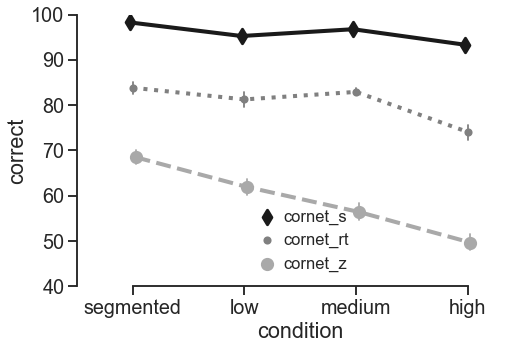

In [50]:
# Initialize the figure
f, ax = plt.subplots(figsize=(8,5))
#sns.despine(bottom=True, left=True)
sns.set(style="whitegrid")
sns.color_palette("Paired")
sns.set(style="ticks")
sns.set_context('talk')

# Show the conditional means
sns.pointplot(x="condition", y="correct", hue="model",hue_order=['cornet_s','cornet_rt', 'cornet_z'],
              data=cornet_data, dodge=.05, join=True, palette=['k', 'gray', 'darkgray'],markers=["d", ".", 'o'],errwidth=1.8,
              linestyles = ['-',':', '--'],
              scale=1, order=["segmented", "low","medium", "high"],bw=.2)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles[:], labels[:],
          handletextpad=0, columnspacing=0.1,
          loc="lower center", frameon=False)

ax.set(ylim=(40,100))

sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 3.5})
sns.despine(offset=0, trim=True)

f.savefig("performance_cornet.tif")

In [51]:
from scipy.stats import friedmanchisquare

means = cornet_data[cornet_data['model']=='cornet_s']
print(means.head(4))

seg = means[means['condition'] == 'segmented']['correct']
low = means[means['condition'] == 'low']['correct']
med = means[means['condition'] == 'medium']['correct']
high = means[means['condition'] == 'high']['correct']

stat, p = friedmanchisquare(seg,low,med,high)
print('Statistics=%.4f, p=%.4f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('At least one with different distribution (reject H0)')

       model  initialization  condition    correct
40  cornet_s               0       high  93.333333
41  cornet_s               0        low  96.666667
42  cornet_s               0     medium  96.666667
43  cornet_s               0  segmented  98.333333
Statistics=26.4687, p=0.0000
At least one with different distribution (reject H0)


In [52]:
from pingouin import mwu
dataZ = cornet_data[cornet_data['model']=='cornet_z']
dataS = cornet_data[cornet_data['model']=='cornet_s']

differenceZ = []
differenceS = []

a1 = dataZ[dataZ['condition']=='segmented']['correct']
a2 =dataZ[dataZ['condition']=='high']['correct']

zip_object = zip(a1, a2)

for list1_i, list2_i in zip_object:
    differenceZ.append(list1_i-list2_i)
    
a1 = dataS[dataS['condition']=='segmented']['correct']
a2 =dataS[dataS['condition']=='high']['correct']

differenceS = []

zip_object = zip(a1, a2)

for list1_i, list2_i in zip_object:
    differenceS.append(list1_i-list2_i)
mwu(differenceZ, differenceS)

,U-val,tail,p-val,RBC,CLES
MWU,100.0,two-sided,0.000178,-1.0,1.0


C:\Users\noors\anaconda3\envs\BP2\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [54]:
models = ['resnet10', 'resnet18', 'resnet34', 'cornet_z', 'cornet_rt', 'cornet_s']
conditions = ['segmented', 'low', 'medium', 'high']
import csv

data= pd.DataFrame()
for model in models:
    for ii in range(10):
        for condition in conditions: 
            data2append = pd.read_csv('E:/Projects/2020_recurrentprocessing/Data/'+model+'_' +str(ii)+'_'+condition+'_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
            data2append['initialization']=ii
            data2append['model']=model
            data2append['condition']=condition
            data=data.append(data2append)


In [57]:
data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data.head(10)

,Unnamed: 0,imageID,pred,ground,initialization,model,condition,correct
0,0,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
1,1,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
2,2,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
3,3,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
4,4,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
5,5,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
6,6,E:/Projects/2020_recurrentprocessing/our_datas...,[1],[0],0,resnet10,segmented,0
7,7,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
8,8,E:/Projects/2020_recurrentprocessing/our_datas...,[0],[0],0,resnet10,segmented,1
9,9,E:/Projects/2020_recurrentprocessing/our_datas...,[3],[0],0,resnet10,segmented,0


In [58]:
resnet_data = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
resnet_data['correct']=resnet_data['correct']*100
resnet_data.head(-10)

,model,initialization,condition,correct
0,cornet_rt,0,high,77.500000
1,cornet_rt,0,low,83.333333
2,cornet_rt,0,medium,84.166667
3,cornet_rt,0,segmented,85.833333
4,cornet_rt,1,high,70.000000
...,...,...,...,...
225,resnet34,6,low,98.333333
226,resnet34,6,medium,99.166667
227,resnet34,6,segmented,97.500000
228,resnet34,7,high,98.333333


['resnet34', 'resnet18', 'resnet10']


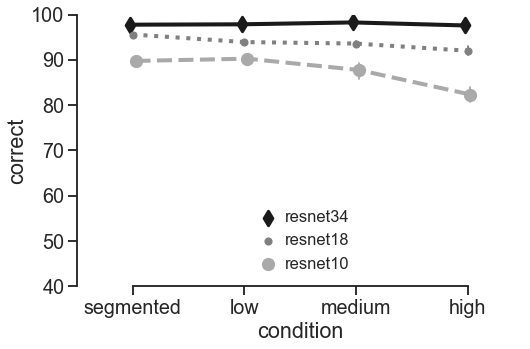

In [62]:
# Initialize the figure
f, ax = plt.subplots(figsize=(8,5))
#sns.despine(bottom=True, left=True)
sns.set(style="whitegrid")
sns.color_palette("Paired")
sns.set(style="ticks")
sns.set_context('talk')

# Show the conditional means
sns.pointplot(x="condition", y="correct", hue="model",hue_order=['resnet34','resnet18','resnet10'],
              data=resnet_data, dodge=.05, join=True, palette=["k","gray", "darkgray"],markers=["d", ".", 'o'],errwidth=1.8,ci=95,
              linestyles = ['-',':', '--'],
              scale=1, order=["segmented", "low","medium", "high"],bw=.3)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles[:], labels[:],
          handletextpad=0, columnspacing=0.1,
          loc="lower center", frameon=False)

ax.set(ylim=(40,100))


#sns.set_context("talk")
#sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 3.5})
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 3.5})

sns.despine(offset=0, trim=True)

f.savefig("performance_resnet.pdf")

In [67]:
from scipy.stats import friedmanchisquare

means = resnet_data[resnet_data['model']=='resnet34']

seg = means[means['condition'] == 'segmented']['correct']
low = means[means['condition'] == 'low']['correct']
med = means[means['condition'] == 'medium']['correct']
high = means[means['condition'] == 'high']['correct']

stat, p = friedmanchisquare(seg,low,med,high)
print('Statistics=%.4f, p=%.4f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('At least one with different distribution (reject H0)')

Statistics=3.2118, p=0.3601
Same distribution (fail to reject H0)


In [68]:
from pingouin import mwu
dataZ = resnet_data[resnet_data['model']=='resnet10']
dataS = resnet_data[resnet_data['model']=='resnet34']

differenceZ = []
differenceS = []

a1 = dataZ[dataZ['condition']=='segmented']['correct']
a2 =dataZ[dataZ['condition']=='high']['correct']

zip_object = zip(a1, a2)

for list1_i, list2_i in zip_object:
    differenceZ.append(list1_i-list2_i)
    
a1 = dataS[dataS['condition']=='segmented']['correct']
a2 =dataS[dataS['condition']=='high']['correct']

differenceS = []

zip_object = zip(a1, a2)

for list1_i, list2_i in zip_object:
    differenceS.append(list1_i-list2_i)
mwu(differenceZ, differenceS)

,U-val,tail,p-val,RBC,CLES
MWU,99.0,two-sided,0.000218,-0.98,0.99
